In [1]:
import pymysql
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Connexion à la base de données
cnx = mysql.connector.connect(
    host='localhost',
    user='root', 
    password='',  
    database='pfe',  
    port=3306 
)

# Requête pour obtenir les données en joignant les tables dim_date et prime_table
query = """
SELECT p.*, d.year AS exercice_comptable___Year
FROM fait_produit p
JOIN dim_date d ON p.id_date = d.id_date
"""

# Charger les données dans un DataFrame
data = pd.read_sql(query, cnx)

# Fermer la connexion à la base de données
cnx.close()

C:\Users\Yassin\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [3]:
data = data[data['prime'] != 0]
data = data[(data['exercice_comptable___Year'] >= 2010) & (data['exercice_comptable___Year'] <= 2023)]

data['nb_primes'] = data.groupby('exercice_comptable___Year')['prime'].transform('count')
# Calculer la somme des primes par année
data['somme_primes'] = data.groupby('exercice_comptable___Year')['prime'].transform('sum')

# Agréger les données par année et calculer le ratio (somme de prime / nombre de prime)
data_aggregated = data.groupby('exercice_comptable___Year').agg({
    'nb_primes': 'sum',
    'somme_primes': 'sum'
}).reset_index()

In [4]:
# Calculer le ratio
data_aggregated['ratio'] = data_aggregated['somme_primes'] / data_aggregated['nb_primes']
X = data_aggregated[['exercice_comptable___Year']]
y = data_aggregated[['ratio']]


In [5]:
#X_train, X_test, y_train, y_test, = train_test_split(x,y,random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define the degree of the polynomial
degree = 2 # You can adjust this as needed

# Create a pipeline with PolynomialFeatures and a regression model (e.g., LinearRegression)
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# Fit the model
model.fit(X, y)
# Predict on the test set
y_pred = model.predict(X_test)

In [6]:
# Predict the primes for the years to predict
years_to_predict = [[2024]]
predicted_ratios = model.predict(years_to_predict)

for year, ratio in zip(years_to_predict, predicted_ratios):
    print(f"Prédiction pour l'année {year[0]} : {ratio[0]}")

Prédiction pour l'année 2024 : 5671.168543040752


C:\Users\Yassin\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [7]:
# Prepare data for plotting
X_future = np.concatenate((X, years_to_predict))
y_future = np.concatenate((y, predicted_ratios))

C:\Users\Yassin\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


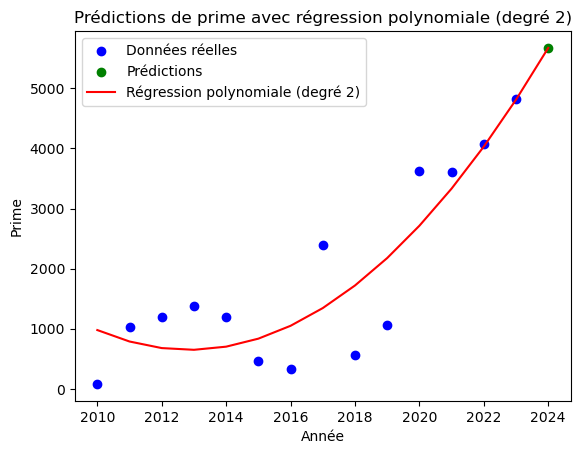

In [8]:
# Plot the data and the predictions
plt.scatter(X, y, color='blue', label='Données réelles')
plt.scatter(years_to_predict,predicted_ratios.flatten(), color='green', label='Prédictions')
plt.plot(X_future, model.predict(X_future), color='red', label='Régression polynomiale (degré {})'.format(degree))
plt.xlabel('Année')
plt.ylabel('Prime')
plt.title('Prédictions de prime avec régression polynomiale (degré {})'.format(degree))
plt.legend()
plt.show()

In [9]:
# Calculate the error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 760.4218649066437
Mean Squared Error (MSE): 704313.0273087984
Root Mean Squared Error (RMSE): 839.2335951979034
R² Score: 0.6803902694967795
